# Network Analysis

Quick sanity checks and plots of a solved PyPSA-Earth network.

## Sync a solved network (from repo root)

```bash
rsync -avz --progress \
  engs2523@arc-login.arc.ox.ac.uk:/data/engs-df-green-ammonia/engs2523/pypsa-earth/results/<run-name>/networks/<network-file>.nc \
  results/<run-name>/networks/
```
Then update `RESULT_PATH` in the next cell to point at the downloaded file.

In [28]:
# Download natura raster on first run
# import cartopy; from cartopy import feature as cf
# cf.NaturalEarthFeature("physical","land","10m")

In [29]:
from pathlib import Path

# Deterministic network selection: choose one candidate unless explicitly overridden.
RESULT_PATH_OVERRIDE = None  # e.g. Path("../results/europe-year-140/networks/elec_s_140_ec_lcopt_Co2L-3h-week01.nc")

RUN_CANDIDATES = {
    "co2_limited": Path("../results/europe-year-140/networks/elec_s_140_ec_lcopt_Co2L-3h.nc"),
    "co2_zero": Path("../results/europe-year-140/networks/elec_s_140_ec_lcopt_Co2zero-3h.nc"),
    "co2_uncapped": Path("../results/europe-year-140/networks/elec_s_140_ec_lcopt_Co2nocap-3h.nc"),
    "h2_sector": Path(
        "../results/europe-year-140-co2-zero-h2-sector/postnetworks/"
        "elec_s_140_ec_lcopt_Co2zero-3h_8760h_2030_0.071_AB_0export.nc"
    ),
}

RESULT_CHOICE = "h2_sector"  # co2_limited | co2_zero | co2_uncapped | h2_sector
DEFAULT_RESULT_PATH = RUN_CANDIDATES.get(RESULT_CHOICE, RUN_CANDIDATES["co2_uncapped"])

candidate = RESULT_PATH_OVERRIDE if RESULT_PATH_OVERRIDE is not None else DEFAULT_RESULT_PATH
RESULT_PATH = candidate.resolve()

if not RESULT_PATH.exists():
    available = "\n".join(f"  - {k}: {v}" for k, v in RUN_CANDIDATES.items())
    raise FileNotFoundError(
        "Solved network missing at expected deterministic path:\n"
        f"  {RESULT_PATH}\n\n"
        "Either sync the file from ARC to this location, set RESULT_PATH_OVERRIDE, "
        "or switch RESULT_CHOICE.\n\nCandidates:\n"
        f"{available}"
    )

print("Using network file:", RESULT_PATH)

Using network file: /Users/carlopalazzi/programming/pypsa_models/pypsa-earth-green-auklet/results/europe-year-140-co2-zero-h2-sector/postnetworks/elec_s_140_ec_lcopt_Co2zero-3h_8760h_2030_0.071_AB_0export.nc


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pypsa
except ImportError as exc:
    raise SystemExit('PyPSA missing. Install via mamba install -c conda-forge pypsa') from exc

try:
    import cartopy  # noqa: F401
    CARTOPY_AVAILABLE = True
except Exception:
    CARTOPY_AVAILABLE = False

print('PyPSA version:', pypsa.__version__)
print('Cartopy available:', CARTOPY_AVAILABLE)

PyPSA version: 0.30.3
Cartopy available: True


In [ ]:
from pathlib import Path

# Compare metrics across the configured annual runs without changing RESULT_CHOICE.
run_candidates = RUN_CANDIDATES if "RUN_CANDIDATES" in globals() else {}


def _extract_co2_limit_tco2(n_local):
    gc = getattr(n_local, "global_constraints", None)
    if gc is None or gc.empty:
        return float("nan")

    mask = pd.Series(True, index=gc.index)
    if "type" in gc.columns:
        mask &= gc["type"].eq("primary_energy")
    if "carrier_attribute" in gc.columns:
        mask &= gc["carrier_attribute"].eq("co2_emissions")

    co2_rows = gc.loc[mask]
    if co2_rows.empty:
        co2_rows = gc.loc[gc.index.astype(str).str.contains("CO2", case=False, regex=True)]
        if co2_rows.empty:
            return float("nan")

    return float(co2_rows.iloc[0].get("constant", float("nan")))


def _compute_metrics(path):
    n_local = pypsa.Network(str(path))
    snapshot_weights = n_local.snapshot_weightings.objective.reindex(n_local.snapshots).fillna(1.0)
    total_demand_mwh = n_local.loads_t.p_set.mul(snapshot_weights, axis=0).sum().sum()
    objective_value = float(getattr(n_local, "objective", float("nan")))
    levelised_cost = (
        objective_value / total_demand_mwh if total_demand_mwh else float("nan")
    )

    co2_limit_tco2 = _extract_co2_limit_tco2(n_local)

    carrier_emissions = n_local.carriers.get("co2_emissions")
    total_co2_mt = float("nan")
    if carrier_emissions is not None and not carrier_emissions.isnull().all():

        def _component_emissions(power_df, component_df):
            if power_df is None or power_df.empty:
                return 0.0
            factors = component_df["carrier"].map(carrier_emissions).fillna(0.0)
            weighted = power_df.mul(snapshot_weights, axis=0)
            return weighted.mul(factors, axis=1).sum().sum()

        gen_emissions = _component_emissions(n_local.generators_t.p, n_local.generators)
        link_emissions = _component_emissions(getattr(n_local.links_t, "p0", None), n_local.links)
        store_emissions = _component_emissions(getattr(n_local.stores_t, "p", None), n_local.stores)
        total_co2_mt = (gen_emissions + link_emissions + store_emissions) / 1e6

    co2_limit_mt = co2_limit_tco2 / 1e6 if pd.notna(co2_limit_tco2) else float("nan")

    return pd.Series({
        "co2_limit_tCO2": co2_limit_tco2,
        "co2_limit_Mt": co2_limit_mt,
        "levelised_cost_EUR_per_MWh": levelised_cost,
        "total_operational_CO2_Mt": total_co2_mt,
    })


rows = {}
for key, path in run_candidates.items():
    candidate_path = Path(path).resolve()
    if not candidate_path.exists():
        rows[key] = pd.Series({
            "co2_limit_tCO2": float("nan"),
            "co2_limit_Mt": float("nan"),
            "levelised_cost_EUR_per_MWh": float("nan"),
            "total_operational_CO2_Mt": float("nan"),
        })
    else:
        rows[key] = _compute_metrics(candidate_path)
    rows[key]["path"] = str(candidate_path)

comparison = pd.DataFrame(rows).T
display(comparison)



In [32]:
n = pypsa.Network(str(RESULT_PATH))
print(n)
print('Snapshots:', list(n.snapshots))
print('Buses:', len(n.buses), 'Lines:', len(n.lines), 'Generators:', len(n.generators))

Index(['CO2 pipeline DE45 0 <-> DE72 0', 'CO2 pipeline DE46 0 <-> DK65 0',
       'CO2 pipeline DK33 0 <-> DK36 0', 'CO2 pipeline DK34 0 <-> DK37 0',
       'CO2 pipeline DK38 0 <-> DK66 0', 'CO2 pipeline DK39 0 <-> DK67 0',
       'CO2 pipeline DK64 0 <-> DK65 0', 'CO2 pipeline DK68 0 <-> GB5 3',
       'CO2 pipeline FR1 0 <-> FR2 0', 'CO2 pipeline FR1 0 <-> FR3 0',
       'CO2 pipeline FR2 0 <-> IT57 0', 'CO2 pipeline FR58 0 <-> IT0 2',
       'CO2 pipeline LT12 0 <-> SE15 0', 'CO2 pipeline NO22 0 <-> NO24 0',
       'CO2 pipeline NO23 0 <-> NO25 0', 'CO2 pipeline SE18 0 <-> SE54 0',
       'CO2 pipeline SE53 0 <-> SE54 0', 'biomass transport DE45 0 <-> DE72 0',
       'biomass transport DE46 0 <-> DK65 0',
       'biomass transport DK33 0 <-> DK36 0',
       'biomass transport DK34 0 <-> DK37 0',
       'biomass transport DK38 0 <-> DK66 0',
       'biomass transport DK39 0 <-> DK67 0',
       'biomass transport DK64 0 <-> DK65 0',
       'biomass transport DK68 0 <-> GB5 3',
      

PyPSA Network
Components:
 - Bus: 2743
 - Carrier: 133
 - Generator: 4276
 - GlobalConstraint: 1
 - Line: 131
 - Link: 7341
 - Load: 3401
 - StorageUnit: 88
 - Store: 1811
Snapshots: 1
Snapshots: [Timestamp('2013-01-01 00:00:00')]
Buses: 2743 Lines: 131 Generators: 4276


## Objective (total system annuity) vs existing
- All monetary rows are in MEUR.
- Levelised cost is in EUR/MWh.

In [33]:
def _series_or_zeros(df, col):
    if col in df.columns:
        return df[col].fillna(0.0)
    return pd.Series(0.0, index=df.index)


def _sum_existing_nameplate_times_capital_cost(df, base_col, cost_col):
    base = _series_or_zeros(df, base_col)
    cost = _series_or_zeros(df, cost_col)
    return (base * cost).sum()


objective_eur = float(n.objective) if hasattr(n, "objective") else float("nan")

sum_existing_nameplate_times_capital_cost_eur = (
    _sum_existing_nameplate_times_capital_cost(n.generators, "p_nom", "capital_cost")
    + _sum_existing_nameplate_times_capital_cost(n.storage_units, "p_nom", "capital_cost")
    + _sum_existing_nameplate_times_capital_cost(n.stores, "e_nom", "capital_cost")
    + _sum_existing_nameplate_times_capital_cost(n.lines, "s_nom", "capital_cost")
    + _sum_existing_nameplate_times_capital_cost(n.links, "p_nom", "capital_cost")
)

objective_minus_sum_existing_nameplate_times_capital_cost = (
    objective_eur - sum_existing_nameplate_times_capital_cost_eur if pd.notna(objective_eur) else float("nan")
)
objective_to_sum_existing_nameplate_times_capital_cost_ratio = (
    objective_eur / sum_existing_nameplate_times_capital_cost_eur
    if pd.notna(objective_eur) and sum_existing_nameplate_times_capital_cost_eur != 0
    else float("nan")
)

snapshot_weights = n.snapshot_weightings.objective.reindex(n.snapshots).fillna(1.0)
total_demand_mwh = n.loads_t.p_set.mul(snapshot_weights, axis=0).sum().sum()
levelised_cost_eur_per_mwh = (
    objective_eur / total_demand_mwh if pd.notna(objective_eur) and total_demand_mwh != 0 else float("nan")
)

carrier_emissions = n.carriers.get("co2_emissions")
if carrier_emissions is None or carrier_emissions.isnull().all():
    total_operational_co2_mt = float("nan")
else:
    def _component_emissions(power_df, component_df):
        if power_df is None or power_df.empty:
            return 0.0
        factors = component_df["carrier"].map(carrier_emissions).fillna(0.0)
        weighted = power_df.mul(snapshot_weights, axis=0)
        return weighted.mul(factors, axis=1).sum().sum()

    gen_emissions = _component_emissions(n.generators_t.p, n.generators)
    link_emissions = _component_emissions(getattr(n.links_t, "p0", None), n.links)
    store_emissions = _component_emissions(getattr(n.stores_t, "p", None), n.stores)
    total_operational_co2_mt = (gen_emissions + link_emissions + store_emissions) / 1e6

summary = pd.Series(
    {
        "objective_MEUR": objective_eur / 1e6,
        "sum_existing_nameplate_times_capital_cost_MEUR": sum_existing_nameplate_times_capital_cost_eur / 1e6,
        "objective_minus_sum_existing_nameplate_times_capital_cost_MEUR": objective_minus_sum_existing_nameplate_times_capital_cost / 1e6,
        "objective_to_sum_existing_nameplate_times_capital_cost_ratio": objective_to_sum_existing_nameplate_times_capital_cost_ratio,
        "levelised_cost_EUR_per_MWh": levelised_cost_eur_per_mwh,
        "total_operational_CO2_Mt": total_operational_co2_mt,
    }
)

display(summary.to_frame("value"))
print("Formula shown explicitly: sum(existing nameplate × capital_cost) over generators, storage_units, stores, lines, and links.")
print("Interpretation: objective includes operating costs and new investment; comparator is only existing nameplate × capital_cost.")
print("For comparison 2025 EU emissions 900 Mt (European Commission)")

,value
objective_MEUR,484386.177599
sum_existing_nameplate_times_capital_cost_MEUR,140732.533684
objective_minus_sum_existing_nameplate_times_capital_cost_MEUR,343653.643915
objective_to_sum_existing_nameplate_times_capital_cost_ratio,3.441892
levelised_cost_EUR_per_MWh,46.741591
total_operational_CO2_Mt,-0.061705


Formula shown explicitly: sum(existing nameplate × capital_cost) over generators, storage_units, stores, lines, and links.
Interpretation: objective includes operating costs and new investment; comparator is only existing nameplate × capital_cost.
For comparison 2025 EU emissions 900 Mt (European Commission)


## Installed capacities (MW)

In [34]:
# Capacity plots: hide emergency load-shedding pseudo-generators by default
INCLUDE_LOAD_SHEDDING_IN_CAPACITY_PLOTS = False

cap_by_carrier_all = n.generators.groupby("carrier")["p_nom"].sum().sort_values(ascending=False)
if INCLUDE_LOAD_SHEDDING_IN_CAPACITY_PLOTS:
    cap_by_carrier = cap_by_carrier_all.copy()
else:
    cap_by_carrier = cap_by_carrier_all.drop(index="load shedding", errors="ignore")

cap_df = cap_by_carrier.to_frame(name="p_nom_MW")
cap_df

,p_nom_MW
carrier,
solar,266130.648715
onwind,218469.608220
nuclear,127889.518175
ror,41554.682643
offwind-dc,29922.719984
geothermal,85.100000
offwind-ac,0.140669
biomass,0.000000
solar rooftop,0.000000


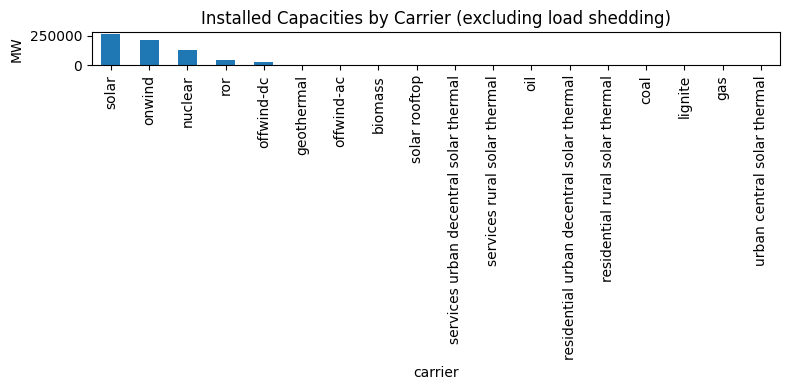

In [35]:
title_suffix = " (excluding load shedding)" if not INCLUDE_LOAD_SHEDDING_IN_CAPACITY_PLOTS else ""
ax = cap_by_carrier.plot(kind="bar", figsize=(8, 4), title=f"Installed Capacities by Carrier{title_suffix}")
ax.set_ylabel("MW")
plt.tight_layout()
plt.show()

In [36]:
# Why is load shedding capacity high but generation low?
print("- Load shedding is very expensive emergency supply (value of lost load).")
print("- Large p_nom is feasibility headroom; this does NOT imply large energy usage.")
print("- A typical run uses a tiny amount of shedding energy relative to total demand.")

- Load shedding is very expensive emergency supply (value of lost load).
- Large p_nom is feasibility headroom; this does NOT imply large energy usage.
- A typical run uses a tiny amount of shedding energy relative to total demand.


## Generation mix (total over modeled period)

In [37]:
# Aggregate generation over the whole modeled period (MWh)
snapshot_weights = n.snapshot_weightings.objective.reindex(n.snapshots).fillna(1.0)
gen_by_generator_mwh = n.generators_t.p.clip(lower=0.0).mul(snapshot_weights, axis=0).sum(axis=0)
tech_mix_total = (
    pd.DataFrame({"mwh": gen_by_generator_mwh, "carrier": n.generators["carrier"]})
    .groupby("carrier")["mwh"]
    .sum()
    .sort_values(ascending=False)
    .rename("generation_MWh")
)
tech_mix_total

carrier
gas                                          2.921704e+09
oil                                          1.447800e+09
biomass                                      1.248367e+09
nuclear                                      1.120312e+09
onwind                                       4.481211e+08
solar                                        2.971304e+08
offwind-dc                                   1.482825e+08
ror                                          1.331687e+08
solar rooftop                                6.233459e+07
geothermal                                   7.454760e+05
offwind-ac                                   5.214810e+02
urban central solar thermal                  5.466726e-07
services urban decentral solar thermal       5.165147e-07
residential urban decentral solar thermal    4.972987e-07
residential rural solar thermal              5.119979e-08
services rural solar thermal                 5.119955e-08
load shedding                                3.189510e-10
lignit

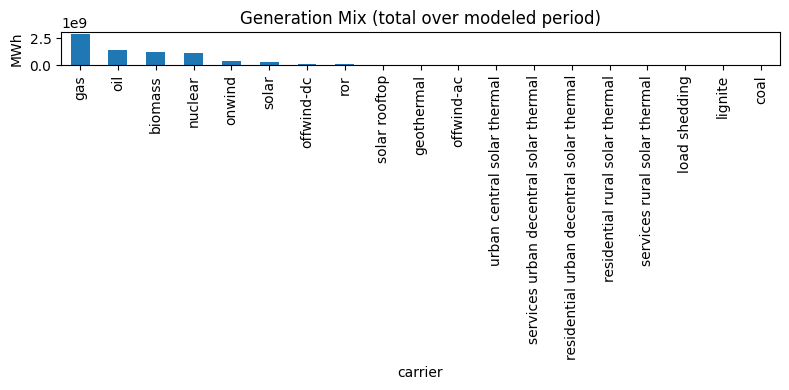

In [38]:
tech_mix_total.plot(kind='bar', figsize=(8, 4), title='Generation Mix (total over modeled period)')
plt.ylabel('MWh')
plt.tight_layout()
plt.show()

## Bus-level capacity pies (MW)

**Note on load shedding**
- `load shedding` is a high-penalty emergency pseudo-generator (`marginal_cost = 100000 EUR/MWh`).
- It is excluded from **capacity** visuals by default for readability.
- It is still included in dispatch/energy diagnostics, so generation totals remain physically/accounting consistent.

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-green-auklet/pypsa-earth/.venv/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


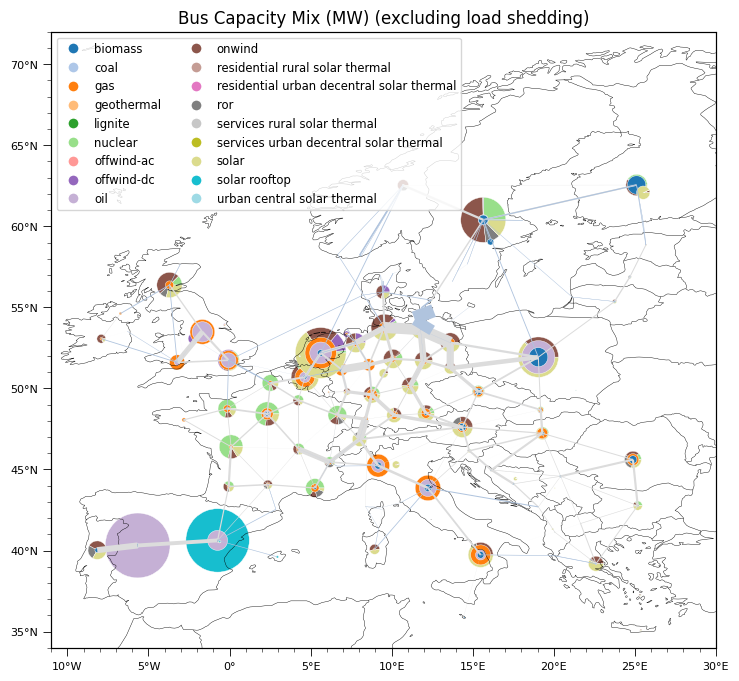

In [39]:
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if CARTOPY_AVAILABLE and not n.generators.empty:
    import cartopy.crs as ccrs
    from matplotlib.patches import Wedge

    # Capacity pies: hide emergency load shedding by default (toggle below if needed)
    INCLUDE_LOAD_SHEDDING_IN_CAPACITY_MAP = False
    gen_for_cap = n.generators if INCLUDE_LOAD_SHEDDING_IN_CAPACITY_MAP else n.generators[n.generators["carrier"] != "load shedding"]

    # Bus/carrier capacity table (MW)
    gen_cap_col = "p_nom_opt" if "p_nom_opt" in gen_for_cap.columns else "p_nom"
    cap_df = (
        gen_for_cap.assign(capacity_MW=gen_for_cap[gen_cap_col].fillna(gen_for_cap["p_nom"]))
        .groupby(["bus", "carrier"])["capacity_MW"]
        .sum()
        .unstack(fill_value=0.0)
    )

    carriers = cap_df.columns.tolist()
    colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
    color_map = dict(zip(carriers, colors))

    line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
    link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)

    pies = cap_df[cap_df.sum(axis=1) > 0]
    if len(pies) == 0:
        print("No capacity data to plot.")
    else:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
        try:
            n.plot(
                ax=ax,
                boundaries=(-11, 30, 34, 72),
                bus_sizes=0.0,
                line_widths=line_widths,
                line_colors="gainsboro",
                link_widths=link_widths,
                link_colors="lightsteelblue",
                branch_components={"Line", "Link"},
            )
        except Exception as exc:
            print("n.plot failed; falling back to plain coastlines:", exc)
            ax.set_extent((-11, 30, 34, 72))
            ax.coastlines()

        max_total = pies.sum(axis=1).max()
        r_scale = 2.0 / max_total if max_total > 0 else 0.0

        for bus, row in pies.iterrows():
            if bus not in n.buses.index:
                continue
            x = n.buses.loc[bus, "x"]
            y = n.buses.loc[bus, "y"]
            total = row.sum()
            if total <= 0:
                continue
            start = 0.0
            radius = total * r_scale
            for carrier in carriers:
                val = row.get(carrier, 0.0)
                if val <= 0:
                    continue
                angle = 360 * val / total
                wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                ax.add_patch(wedge)
                start += angle

        legend_handles = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
            for c in carriers
        ]
        ax.legend(handles=legend_handles, loc="upper left", fontsize="small", ncol=2, frameon=True)

        ax.set_axis_on()
        for spine in ax.spines.values():
            spine.set_visible(True)
        ax.set_xlim(-11, 30)
        ax.set_ylim(34, 72)

        major_xticks = np.arange(-10, 31, 5)
        major_yticks = np.arange(35, 73, 5)
        ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.tick_params(axis="both", which="major", labelsize=8, length=6, width=0.6, direction="out")
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
        ax.tick_params(axis="both", which="minor", length=3, width=0.4, direction="out")
        title_suffix = " (excluding load shedding)" if not INCLUDE_LOAD_SHEDDING_IN_CAPACITY_MAP else ""
        ax.set_title(f"Bus Capacity Mix (MW){title_suffix}")
        plt.show()
elif not CARTOPY_AVAILABLE:
    print("Cartopy not available; skipping capacity pie map.")
else:
    print("No generators available in this network file.")

## Bus-level generation pies (MWh)

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-green-auklet/pypsa-earth/.venv/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


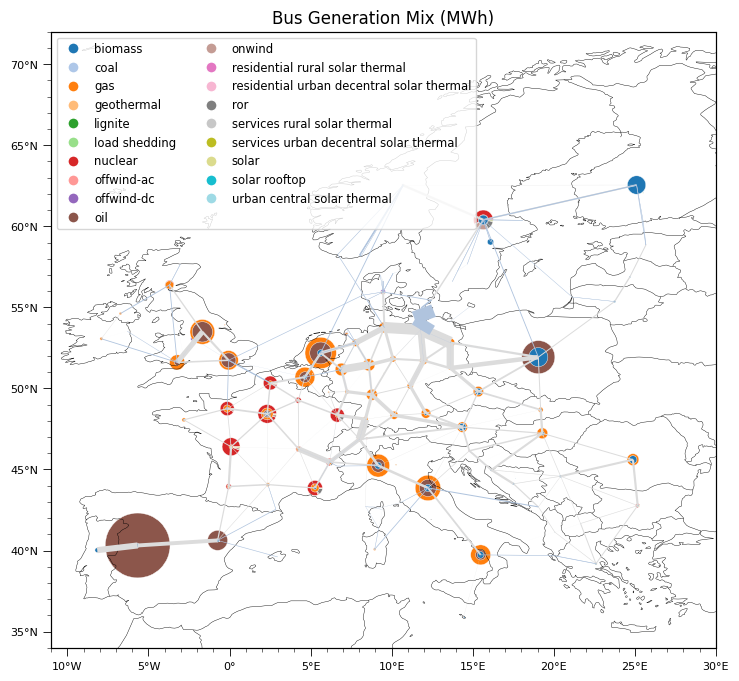

In [40]:
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if CARTOPY_AVAILABLE and not n.generators.empty:
    import cartopy.crs as ccrs
    from matplotlib.patches import Wedge

    snapshot_weights = n.snapshot_weightings.objective.reindex(n.snapshots).fillna(1.0)
    gen_by_generator_mwh = n.generators_t.p.clip(lower=0.0).mul(snapshot_weights, axis=0).sum(axis=0)
    gen_df = (
        pd.DataFrame(
            {
                "generation_MWh": gen_by_generator_mwh,
                "bus": n.generators["bus"],
                "carrier": n.generators["carrier"],
            }
        )
        .groupby(["bus", "carrier"])["generation_MWh"]
        .sum()
        .unstack(fill_value=0.0)
    )

    carriers = gen_df.columns.tolist()
    colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
    color_map = dict(zip(carriers, colors))

    line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
    link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)

    pies = gen_df[gen_df.sum(axis=1) > 0]
    if len(pies) == 0:
        print("No generation data to plot.")
    else:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
        try:
            n.plot(
                ax=ax,
                boundaries=(-11, 30, 34, 72),
                bus_sizes=0.0,
                line_widths=line_widths,
                line_colors="gainsboro",
                link_widths=link_widths,
                link_colors="lightsteelblue",
                branch_components={"Line", "Link"},
            )
        except Exception as exc:
            print("n.plot failed; falling back to plain coastlines:", exc)
            ax.set_extent((-11, 30, 34, 72))
            ax.coastlines()

        max_total = pies.sum(axis=1).max()
        r_scale = 2.0 / max_total if max_total > 0 else 0.0

        for bus, row in pies.iterrows():
            if bus not in n.buses.index:
                continue
            x = n.buses.loc[bus, "x"]
            y = n.buses.loc[bus, "y"]
            total = row.sum()
            if total <= 0:
                continue
            start = 0.0
            radius = total * r_scale
            for carrier in carriers:
                val = row.get(carrier, 0.0)
                if val <= 0:
                    continue
                angle = 360 * val / total
                wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                ax.add_patch(wedge)
                start += angle

        legend_handles = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
            for c in carriers
        ]
        ax.legend(handles=legend_handles, loc="upper left", fontsize="small", ncol=2, frameon=True)

        ax.set_axis_on()
        for spine in ax.spines.values():
            spine.set_visible(True)
        ax.set_xlim(-11, 30)
        ax.set_ylim(34, 72)

        major_xticks = np.arange(-10, 31, 5)
        major_yticks = np.arange(35, 73, 5)
        ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.tick_params(axis="both", which="major", labelsize=8, length=6, width=0.6, direction="out")
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
        ax.tick_params(axis="both", which="minor", length=3, width=0.4, direction="out")
        ax.set_title("Bus Generation Mix (MWh)")
        plt.show()
elif not CARTOPY_AVAILABLE:
    print("Cartopy not available; skipping generation pie map.")
else:
    print("No generators available in this network file.")

## Line loading distribution (all snapshots)

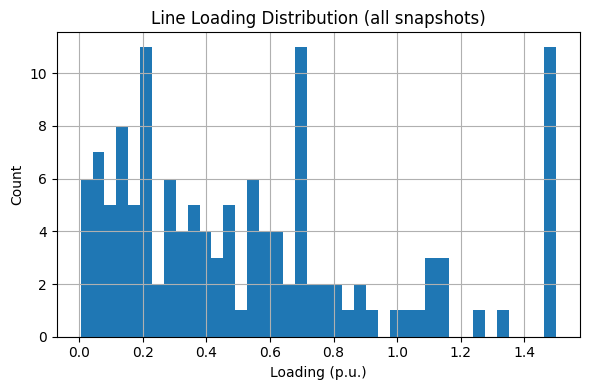

In [41]:
import numpy as np

if "p0" in n.lines_t:
    loading_all = n.lines_t.p0.abs().div(n.lines.s_nom, axis=1)
    loading = loading_all.replace([np.inf, -np.inf], np.nan).stack().dropna()
    plt.figure(figsize=(6, 4))
    loading.clip(upper=1.5).hist(bins=40)
    plt.title("Line Loading Distribution (all snapshots)")
    plt.xlabel("Loading (p.u.)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Line flow results missing in network file.")

## Marginal prices (period summary)

In [42]:
if "marginal_price" in n.buses_t:
    price_stats = pd.DataFrame({
        "mean_EUR_per_MWh": n.buses_t.marginal_price.mean(axis=0),
        "median_EUR_per_MWh": n.buses_t.marginal_price.median(axis=0),
        "p95_EUR_per_MWh": n.buses_t.marginal_price.quantile(0.95, axis=0),
    }).dropna().sort_values("mean_EUR_per_MWh", ascending=False)
    price_stats.head(10)
else:
    print("No marginal prices stored in buses_t.")